In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torchvision import transforms, datasets
import torchvision.transforms.functional as fn
import torchvision.transforms
from PIL import Image

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [70]:
transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
        #                     [0.229, 0.224, 0.225])
])

In [71]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.5, 0.5, 0.5], 
                                                            #[0.5, 0.5, 0.5])])
                                    ])

In [72]:
train_dataset = ImageFolder('data/Vegetable Images/train', transform=train_transform)
val_dataset = ImageFolder('data/Vegetable Images/validation', transform=transform)
test_dataset = ImageFolder('data/Vegetable Images/test', transform=transform)


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



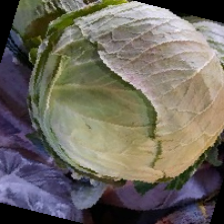

In [73]:
images, labels = next(iter(train_dataloader))
fn.to_pil_image(images[0])

In [74]:
print(train_dataset.classes)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [75]:
class VegetableClassifier(nn.Module):
    def __init__(self, out_size=15) -> None:
        super(VegetableClassifier, self).__init__()
        self.linear_out_size = out_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size= (7,7), stride=(2,2), padding=(3,3), bias=False), #maybe add bias?
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
        )
        self.avg_maxpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear_classifier = nn.Linear(in_features=64, out_features=self.linear_out_size)
        
    def forward(self, input):
        input = self.network(input)
        input = self.avg_maxpool(input)
        input = torch.flatten(input, 1)
        return self.linear_classifier(input)
                

In [76]:
WANDB_LOGGING = False

In [77]:

import wandb
if WANDB_LOGGING:
    wandb.init()

In [78]:
from tqdm.auto import tqdm

def get_accuracy(pred, y):
    correct = torch.eq(y, pred).sum().item()
    acc = (correct / len(pred)) * 100 
    return acc

def fit(model: nn.Module,
        device: torch.device,
        num_epochs: int,
          loss_fn,
            optimizer: torch.optim.Optimizer,
              train_dataloader: DataLoader,
                test_dataloader: DataLoader,
                  print_rate: int = 100):
    # Iterate through epochs with tqdm
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch: {epoch}\n")
        # Setup train loss that will accumulate over each batch
        train_loss = 0
        # Iterate through batches in each epoch
        for batch, (X, y) in enumerate(train_dataloader):
            # Pass the tensors to device
            X, y = X.to(device), y.to(device)
            # Set mode of model to train
            model.train()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % print_rate == 0: 
                print(f"Looked at {batch} Batches\t---\t{batch * len(X)}/{len(train_dataloader.dataset)} Samples")
        # Devide the train_loss by the number of batches to get the average train_loss
        avg_train_loss = train_loss / len(train_dataloader)

        # Testing
        # Setup the Test Loss and Accuracy to accumulate over the batches in the test data set
        test_loss = 0
        test_acc = 0
        # Set model to evaluation mode and use torch.inference_mode to remove unnecessary training operations 
        model.eval()
        with torch.inference_mode():
            for X_test, y_test in test_dataloader:
                X_test, y_test = X_test.to(device), y_test.to(device)

                test_pred = model(X_test)
                test_loss += loss_fn(test_pred, y_test)
                test_acc += get_accuracy(pred=test_pred.argmax(dim=1), y=y_test)

        # Get the average Test Loss and Accuracy
        avg_test_loss = test_loss / len(test_dataloader)
        avg_test_acc = test_acc / len(test_dataloader)

        print(f"Train loss: {avg_train_loss} | Test Loss: {avg_test_loss} | Test Accuracy: {avg_test_acc}")
        if WANDB_LOGGING:
            wandb.log({"Train Loss": avg_train_loss,"Test Loss": avg_test_loss, "Test Accuracy": avg_test_acc})

In [79]:
model = VegetableClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
loss_fn = nn.CrossEntropyLoss()

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device=device)
fit(model=model, num_epochs=5, device=device, loss_fn=loss_fn, optimizer=optimizer, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	3200/15000 Samples
Looked at 200 Batches	---	6400/15000 Samples
Looked at 300 Batches	---	9600/15000 Samples
Looked at 400 Batches	---	12800/15000 Samples


 20%|██        | 1/5 [01:07<04:31, 67.90s/it]

Train loss: 1.2503448724746704 | Test Loss: 1.4005495309829712 | Test Accuracy: 55.70700354609929
Epoch: 1

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	3200/15000 Samples
Looked at 200 Batches	---	6400/15000 Samples
Looked at 300 Batches	---	9600/15000 Samples
Looked at 400 Batches	---	12800/15000 Samples


 40%|████      | 2/5 [02:12<03:18, 66.02s/it]

Train loss: 0.7032817602157593 | Test Loss: 1.1431918144226074 | Test Accuracy: 61.569148936170215
Epoch: 2

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	3200/15000 Samples
Looked at 200 Batches	---	6400/15000 Samples
Looked at 300 Batches	---	9600/15000 Samples
Looked at 400 Batches	---	12800/15000 Samples


 60%|██████    | 3/5 [03:17<02:11, 65.60s/it]

Train loss: 0.5427751541137695 | Test Loss: 1.910368800163269 | Test Accuracy: 54.388297872340424
Epoch: 3

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	3200/15000 Samples
Looked at 200 Batches	---	6400/15000 Samples
Looked at 300 Batches	---	9600/15000 Samples
Looked at 400 Batches	---	12800/15000 Samples


 80%|████████  | 4/5 [04:23<01:05, 65.82s/it]

Train loss: 0.4548185467720032 | Test Loss: 0.7136682271957397 | Test Accuracy: 76.11923758865248
Epoch: 4

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	3200/15000 Samples
Looked at 200 Batches	---	6400/15000 Samples
Looked at 300 Batches	---	9600/15000 Samples
Looked at 400 Batches	---	12800/15000 Samples


100%|██████████| 5/5 [05:29<00:00, 65.86s/it]

Train loss: 0.4052378237247467 | Test Loss: 2.5114047527313232 | Test Accuracy: 50.52083333333333
